# Assignment 4

**The purpose of the assignment**  
Enabling students to experiment with creating two generative architectures: a) standard GAN, and; b) a
modified GAN architecture. The students will work on real-world data and challenges.

**Introduction**  
Generative models are among the most exciting architecture in the field of deep learning today. Their
ability to generate high-quality data with little-to-no interaction or knowledge with the existing data
enables us to accomplish tasks thought impossible not long ago. In this assignment you will implement
two generative models, each dealing with a different scenario. The first generative model is a simple GAN,
which you will implement on two tabular datasets (we will not use image datasets as the running times
are significantly longer). The second GAN model offers in interesting “twist” in the sense that you will NOT
have access to any “real” data.

## Id numbers and names

1.   313326985 Shahar Shcheranski
2.   206172686 Sarit Hollander

## Imports

In [ ]:
!pip install table_evaluator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 285 kB 6.3 MB/s 
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.2
    Uninstalling seaborn-0.11.2:
      Successfully uninstalled seaborn-0.11.2


In [ ]:
from scipy.io import arff
import pandas as pd
import numpy as np
from numpy.random import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from numpy import complexfloating
from table_evaluator import load_data, TableEvaluator

import tensorflow as tf
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Concatenate
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.losses import BinaryCrossentropy
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.optimizer_v2.rmsprop import RMSprop


from keras.layers import Dense
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn import metrics
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
import random
from sklearn.decomposition import PCA

In [ ]:
my_seed = 10   
random.seed(my_seed)
np.random.seed(my_seed)
tf.random.set_seed(my_seed)

## Part 1 – Generative Adversarial Networks

In this part we will implement a simple GAN model for tabular data.

### Loading data

In [ ]:
url_data = "https://drive.google.com/file/d/1DZrN4YGySWn1zQRRW06hGCUchpALCA0G/view?usp=sharing"

In [ ]:
!gdown --id 1DZrN4YGySWn1zQRRW06hGCUchpALCA0G

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1DZrN4YGySWn1zQRRW06hGCUchpALCA0G
To: /content/Assignment_4_files.zip
100% 26.0k/26.0k [00:00<00:00, 34.0MB/s]


In [ ]:
!unzip -q /content/Assignment_4_files.zip

In [ ]:
# Loading diabetes data set
data_diabetes = arff.loadarff('./Assignment_4_files/diabetes.arff')
df_diabetes = pd.DataFrame(data_diabetes[0])
# Remove the 'b' charcter 
df_diabetes['class'] = df_diabetes['class'].apply(lambda x: x.decode("utf-8"))
df_diabetes

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6.0,148.0,72.0,35.0,0.0,33.6,0.627,50.0,tested_positive
1,1.0,85.0,66.0,29.0,0.0,26.6,0.351,31.0,tested_negative
2,8.0,183.0,64.0,0.0,0.0,23.3,0.672,32.0,tested_positive
3,1.0,89.0,66.0,23.0,94.0,28.1,0.167,21.0,tested_negative
4,0.0,137.0,40.0,35.0,168.0,43.1,2.288,33.0,tested_positive
...,...,...,...,...,...,...,...,...,...
763,10.0,101.0,76.0,48.0,180.0,32.9,0.171,63.0,tested_negative
764,2.0,122.0,70.0,27.0,0.0,36.8,0.340,27.0,tested_negative
765,5.0,121.0,72.0,23.0,112.0,26.2,0.245,30.0,tested_negative
766,1.0,126.0,60.0,0.0,0.0,30.1,0.349,47.0,tested_positive


In [ ]:
df_diabetes['class'].value_counts()

tested_negative    500
tested_positive    268
Name: class, dtype: int64

In [ ]:
# Loading german credit data set
data_german_credit = arff.loadarff('./Assignment_4_files/german_credit.arff')
df_german_credit = pd.DataFrame(data_german_credit[0])
# Remove the 'b' charcter
for col in df_german_credit.columns:
  if str(df_german_credit[col].dtypes) == 'object':
    df_german_credit[col] = df_german_credit[col].apply(lambda x: x.decode("utf-8"))

df_german_credit

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,A11,6.0,A34,A43,1169.0,A65,A75,4.0,A93,A101,...,A121,67.0,A143,A152,2.0,A173,1.0,A192,A201,1
1,A12,48.0,A32,A43,5951.0,A61,A73,2.0,A92,A101,...,A121,22.0,A143,A152,1.0,A173,1.0,A191,A201,2
2,A14,12.0,A34,A46,2096.0,A61,A74,2.0,A93,A101,...,A121,49.0,A143,A152,1.0,A172,2.0,A191,A201,1
3,A11,42.0,A32,A42,7882.0,A61,A74,2.0,A93,A103,...,A122,45.0,A143,A153,1.0,A173,2.0,A191,A201,1
4,A11,24.0,A33,A40,4870.0,A61,A73,3.0,A93,A101,...,A124,53.0,A143,A153,2.0,A173,2.0,A191,A201,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,A14,12.0,A32,A42,1736.0,A61,A74,3.0,A92,A101,...,A121,31.0,A143,A152,1.0,A172,1.0,A191,A201,1
996,A11,30.0,A32,A41,3857.0,A61,A73,4.0,A91,A101,...,A122,40.0,A143,A152,1.0,A174,1.0,A192,A201,1
997,A14,12.0,A32,A43,804.0,A61,A75,4.0,A93,A101,...,A123,38.0,A143,A152,1.0,A173,1.0,A191,A201,1
998,A11,45.0,A32,A43,1845.0,A61,A73,4.0,A93,A101,...,A124,23.0,A143,A153,1.0,A173,1.0,A192,A201,2


In [ ]:
df_german_credit['21'].value_counts()

1    700
2    300
Name: 21, dtype: int64

### Preprocessing

#### Diabetes



1.   Transform the numeric features by scaling each feature to a range zero and one.
2.   Transform the class to one and zero:

  *   $tested\_positive \rightarrow 1$
  *   $tested\_ negative \rightarrow 0$





In [ ]:
df_diabetes['class'] = df_diabetes['class'].apply(lambda x: 1 if x == 'tested_positive' else 0)
df_diabetes['class'].value_counts() 

0    500
1    268
Name: class, dtype: int64

In [ ]:
# MinMaxScaler
diabetes_scaler = MinMaxScaler()
df_diabetes.loc[:, df_diabetes.columns != 'class'] = diabetes_scaler.fit_transform(df_diabetes.loc[:, df_diabetes.columns != 'class'])
df_diabetes

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,0.352941,0.743719,0.590164,0.353535,0.000000,0.500745,0.234415,0.483333,1
1,0.058824,0.427136,0.540984,0.292929,0.000000,0.396423,0.116567,0.166667,0
2,0.470588,0.919598,0.524590,0.000000,0.000000,0.347243,0.253629,0.183333,1
3,0.058824,0.447236,0.540984,0.232323,0.111111,0.418778,0.038002,0.000000,0
4,0.000000,0.688442,0.327869,0.353535,0.198582,0.642325,0.943638,0.200000,1
...,...,...,...,...,...,...,...,...,...
763,0.588235,0.507538,0.622951,0.484848,0.212766,0.490313,0.039710,0.700000,0
764,0.117647,0.613065,0.573770,0.272727,0.000000,0.548435,0.111870,0.100000,0
765,0.294118,0.608040,0.590164,0.232323,0.132388,0.390462,0.071307,0.150000,0
766,0.058824,0.633166,0.491803,0.000000,0.000000,0.448584,0.115713,0.433333,1


#### German Credit

1.   Transform the non-numerical features to numerical features.
2.   Transform the numerical features by scaling each feature to a range zero and one.
3.   Transform the class to one and zero:

  *   $'1' \rightarrow 1$
  *   $'2' \rightarrow 0$


In [ ]:
df_german_credit['21'] = df_german_credit['21'].apply(lambda x: 1 if x == '1' else 0)
df_german_credit['21'].value_counts() 

1    700
0    300
Name: 21, dtype: int64

In [ ]:
# LabelEncoder
label_encoders = {}
for col in df_german_credit.columns:
  if str(df_german_credit[col].dtypes) == 'object':
    le = LabelEncoder()
    label_encoders[col] = le
    df_german_credit[col] = le.fit_transform(df_german_credit[col])

In [ ]:
# MinMaxScaler
german_credit_scaler = MinMaxScaler()
df_german_credit.loc[:, df_german_credit.columns != '21'] = german_credit_scaler.fit_transform(df_german_credit.loc[:, df_german_credit.columns != '21'])
df_german_credit

,1,2,3,4,5,6,7,8,9,10,...,12,13,14,15,16,17,18,19,20,21
0,0.000000,0.029412,1.00,0.444444,0.050567,1.00,1.00,1.000000,0.666667,0.0,...,0.000000,0.857143,1.0,0.5,0.333333,0.666667,0.0,1.0,0.0,1
1,0.333333,0.647059,0.50,0.444444,0.313690,0.00,0.50,0.333333,0.333333,0.0,...,0.000000,0.053571,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0,0
2,1.000000,0.117647,1.00,0.777778,0.101574,0.00,0.75,0.333333,0.666667,0.0,...,0.000000,0.535714,1.0,0.5,0.000000,0.333333,1.0,0.0,0.0,1
3,0.000000,0.558824,0.50,0.333333,0.419941,0.00,0.75,0.333333,0.666667,1.0,...,0.333333,0.464286,1.0,1.0,0.000000,0.666667,1.0,0.0,0.0,1
4,0.000000,0.294118,0.75,0.000000,0.254209,0.00,0.50,0.666667,0.666667,0.0,...,1.000000,0.607143,1.0,1.0,0.333333,0.666667,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.000000,0.117647,0.50,0.333333,0.081765,0.00,0.75,0.666667,0.333333,0.0,...,0.000000,0.214286,1.0,0.5,0.000000,0.333333,0.0,0.0,0.0,1
996,0.000000,0.382353,0.50,0.111111,0.198470,0.00,0.50,1.000000,0.000000,0.0,...,0.333333,0.375000,1.0,0.5,0.000000,1.000000,0.0,1.0,0.0,1
997,1.000000,0.117647,0.50,0.444444,0.030483,0.00,1.00,1.000000,0.666667,0.0,...,0.666667,0.339286,1.0,0.5,0.000000,0.666667,0.0,0.0,0.0,1
998,0.000000,0.602941,0.50,0.444444,0.087763,0.00,0.50,1.000000,0.666667,0.0,...,1.000000,0.071429,1.0,1.0,0.000000,0.666667,0.0,1.0,0.0,0


### Train a Gan

In [ ]:
# Create random noise in the latent space and be reshaped to the dimensions for matching the input of generator model
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# Use the generator to generate n fake examples, with class labels
# Because it is the fake data, the label will be 0.
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [ ]:
# Generate n real samples with class labels; We randomly select n samples from the real data
# The label for the real data sample is 1
def generate_real_samples(data):
    X = data
    y = np.ones((len(data), 1))
    return X, y

#### Generator Architecture

In [ ]:
# The input dimension will be the same as the dimension of input samples.
# The output dimension will be the same as the dimension of the dataset
def define_generator(latent_dim, n_outputs):

  input_noise = Input(shape=(latent_dim,))

  X = Dense(256, activation=LeakyReLU(alpha=0.2))(input_noise)
  X = BatchNormalization()(X)
  X = Dense(256, activation=LeakyReLU(alpha=0.2))(X)
  X = BatchNormalization()(X)

  output = Dense(n_outputs, activation='sigmoid')(X)

  generator = Model(inputs=input_noise, outputs=output)
    
  return generator

#### Discriminator Architecture

In [ ]:
# The input samples are real (True) or fake (False).
def define_discriminator(n_inputs):

  input = Input(shape=(n_inputs,))

  X = Dense(256, activation=LeakyReLU(alpha=0.2))(input)
  X = BatchNormalization()(X)
  X = Dropout(0.2)(X)
  X = Dense(256, activation=LeakyReLU(alpha=0.2))(X)
  X = BatchNormalization()(X)
  X = Dropout(0.2)(X)
    
  output = Dense(1, activation='sigmoid')(X)

  discriminator = Model(input, output)

  # compile model
  discriminator.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])
    
  return discriminator

#### GAN Architecture

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):

    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4))

    return model

In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    df_loss = pd.DataFrame(data={'Discriminator Loss': d_hist, 'Generator Loss': g_hist})
    # plot loss
    plt.figure(figsize=(30, 10))
    handle = plt.plot(df_loss)
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.legend(handle, df_loss.columns)
    plt.show()

In [ ]:
# train the generator and discriminator
def train(dataset_name, dataset, g_model, d_model, gan_model, latent_dim, n_epochs=1000, n_batch=16):
    my_seed = 10   
    random.seed(my_seed)
    np.random.seed(my_seed)
    tf.random.set_seed(my_seed)

    ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(dataset.to_numpy())).shuffle(buffer_size=10000).batch(n_batch)

    d_history = []
    g_history = []
    # manually enumerate epochs
    for epoch in tqdm(range(n_epochs)):
      d_epoch_history = []
      g_epoch_history = []

      for batch_ds in ds:
        # prepare real samples
        x_real, y_real = generate_real_samples(batch_ds)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        # update discriminator
        d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
        d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)

        d_epoch_history.append(d_loss)
        g_epoch_history.append(g_loss_fake)

      d_history.append(np.mean(d_epoch_history))
      g_history.append(np.mean(g_epoch_history))

    plot_history(d_history, g_history)
    g_model.save(f'{dataset_name}_trained_generated_model.h5')
    d_model.save(f'{dataset_name}_trained_discriminator_model.h5')
    return g_model, d_model

#### Diabetes

In [ ]:
# size of the latent space
latent_dim = 30

X_diabetes = df_diabetes.iloc[:,:-1]

In [ ]:
# create the generator
generator_diabetes = define_generator(latent_dim, X_diabetes.shape[1])
generator_diabetes.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense (Dense)               (None, 256)               7936      
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 8)                 2056  

In [ ]:
# create the discriminator
discriminator_diabetes = define_discriminator(X_diabetes.shape[1])
discriminator_diabetes.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 8)]               0         
                                                                 
 dense_3 (Dense)             (None, 256)               2304      
                                                                 
 batch_normalization_2 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                           

In [ ]:
gan_diabetes = define_gan(generator_diabetes, discriminator_diabetes)
gan_diabetes.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model (Functional)          (None, 8)                 77832     
                                                                 
 model_1 (Functional)        (None, 1)                 70401     
                                                                 
Total params: 148,233
Trainable params: 76,808
Non-trainable params: 71,425
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/200 [00:00<?, ?it/s]

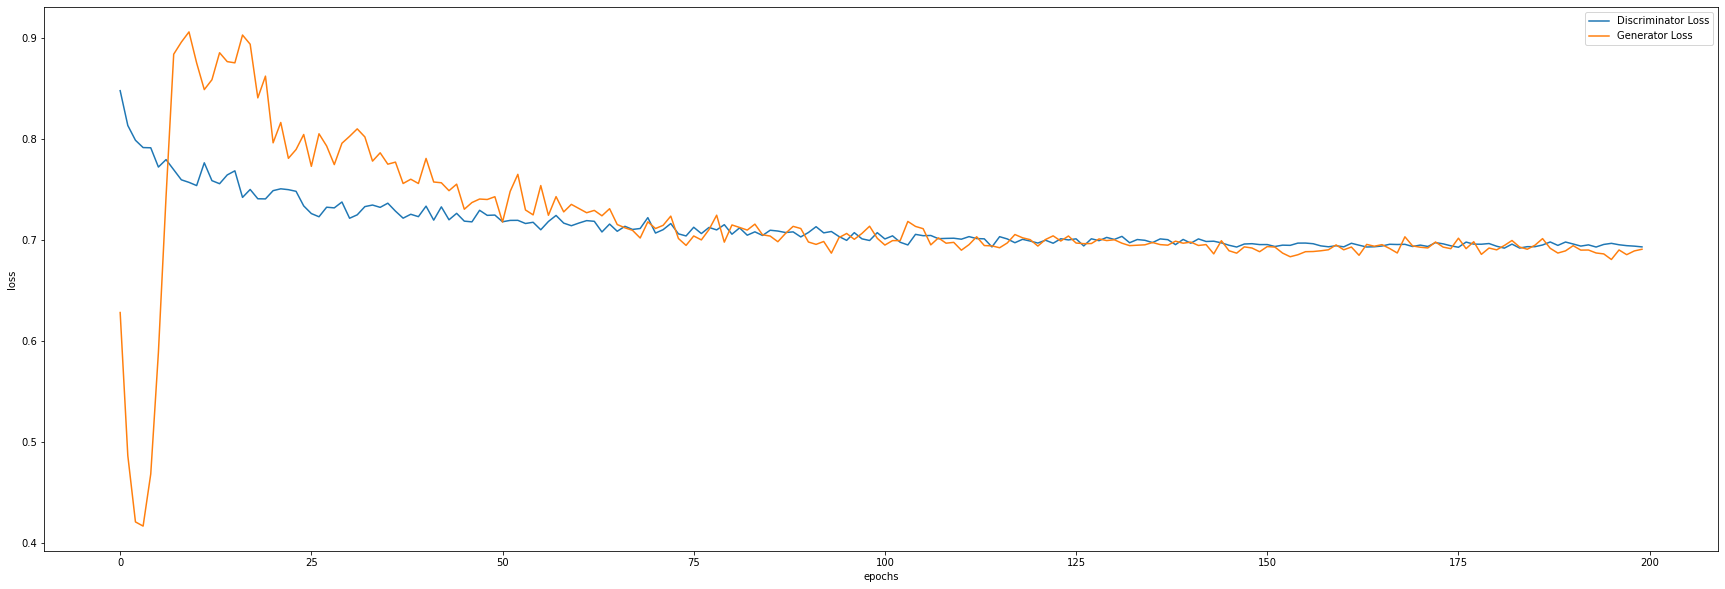

In [ ]:
# train model
g_diabetes_model, d_diabetes_model = train('diabetes', X_diabetes ,generator_diabetes, discriminator_diabetes, gan_diabetes ,latent_dim, n_epochs=200)

#### German Credit

In [ ]:
# size of the latent space
latent_dim = 30

X_german_credit = df_german_credit.iloc[:,:-1]

In [ ]:
# create the generator
generator_german_credit = define_generator(latent_dim, X_german_credit.shape[1])
generator_german_credit.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 30)]              0         
                                                                 
 dense_24 (Dense)            (None, 256)               7936      
                                                                 
 batch_normalization_16 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_25 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_17 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dense_26 (Dense)            (None, 20)                5140

In [ ]:
# create the discriminator
discriminator_german_credit = define_discriminator(X_german_credit.shape[1])
discriminator_german_credit.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20)]              0         
                                                                 
 dense_27 (Dense)            (None, 256)               5376      
                                                                 
 batch_normalization_18 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 256)               0         
                                                                 
 dense_28 (Dense)            (None, 256)               65792     
                                                                 
 batch_normalization_19 (Bat  (None, 256)              1024      
 chNormalization)                                          

In [ ]:
gan_german_credit = define_gan(generator_german_credit, discriminator_german_credit)
gan_german_credit.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_8 (Functional)        (None, 20)                80916     
                                                                 
 model_9 (Functional)        (None, 1)                 73473     
                                                                 
Total params: 154,389
Trainable params: 79,892
Non-trainable params: 74,497
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/200 [00:00<?, ?it/s]

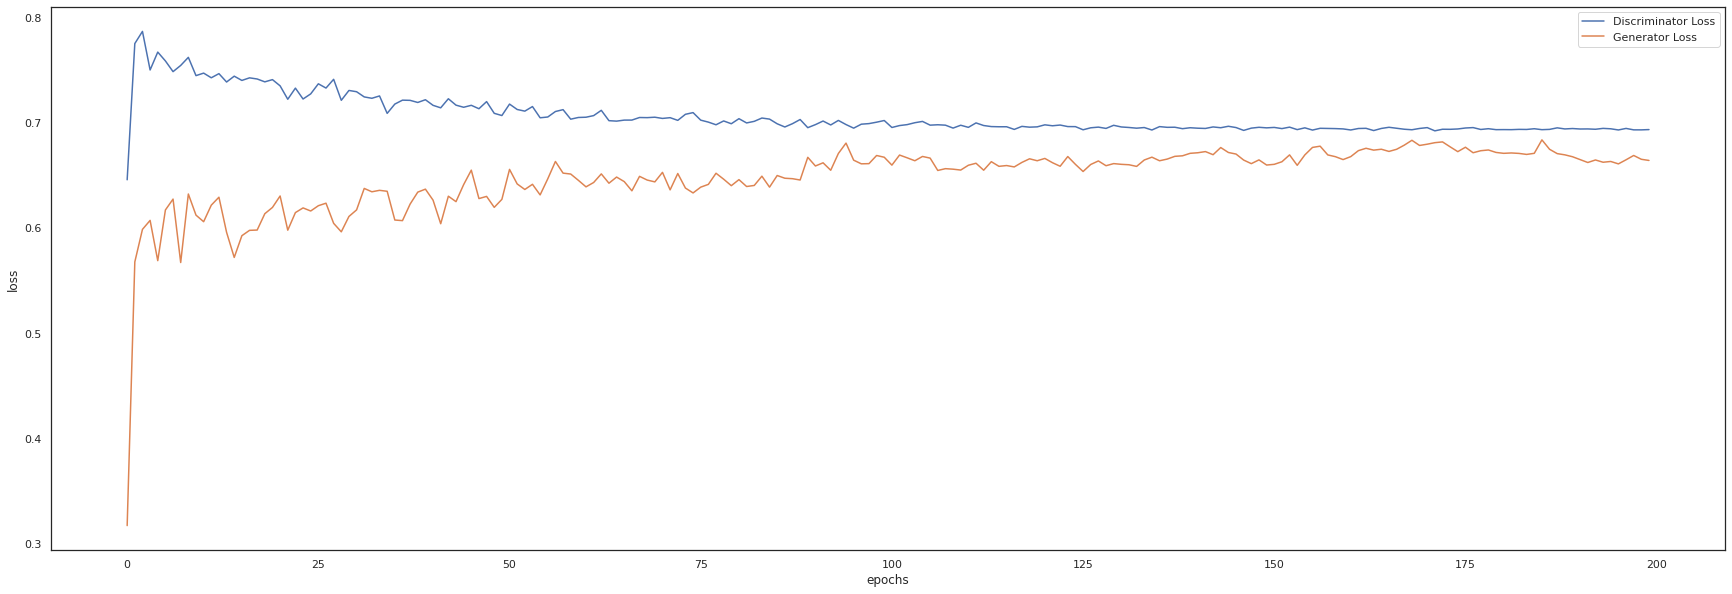

In [ ]:
# train model
g_credit_model, d_credit_model = train('german_credit', X_german_credit ,generator_german_credit, discriminator_german_credit, gan_german_credit ,latent_dim, n_epochs=200)

### Analyze the products of our model

#### Diabetes

##### section a

In [ ]:
latent_points = generate_latent_points(latent_dim, 100)
X = g_diabetes_model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['preg',	'plas',	'pres',	'skin',	'insu',	'mass',	'pedi',	'age'])

In [ ]:
X_dis = d_diabetes_model(data_fake.to_numpy())

In [ ]:
fooled = np.where(np.any(X_dis > 0.5, axis=1))
not_fooled = np.where(np.any(X_dis < 0.5, axis=1))

In [ ]:
data_fake_inv = data_fake
data_fake_inv = pd.DataFrame(data=diabetes_scaler.inverse_transform(data_fake_inv),  columns=['preg',	'plas',	'pres',	'skin',	'insu',	'mass',	'pedi',	'age'])

**Here a several samples that “fooled” the detector:**


In [ ]:
fooled_df = data_fake_inv.iloc[fooled]
fooled_df

,preg,plas,pres,skin,insu,mass,pedi,age
1,9.442034,78.098351,98.246086,8.477028,192.585037,50.904148,0.227754,80.044655
2,9.882927,83.435226,36.806713,29.056288,72.707130,40.157364,0.440857,26.797838
4,9.862481,60.107925,83.449249,41.497044,166.573029,57.343826,1.227755,71.372681
6,7.956937,17.932354,1.761106,30.031279,3.793034,62.372276,1.003890,23.061424
10,7.311961,119.310211,62.467304,25.068405,138.603714,41.527843,0.641523,56.869781
...,...,...,...,...,...,...,...,...
92,4.905341,85.431511,18.710117,16.605730,4.125288,55.427589,0.174986,21.565638
93,3.998969,117.403900,29.186636,32.383846,50.014587,40.564018,1.053639,29.022583
95,3.347734,108.464409,21.432499,12.703938,10.996850,42.958126,0.252160,21.109182
97,7.719701,125.099167,69.020096,10.128746,40.865253,48.011642,0.335521,21.414043


**Here a several that did not “fooled” the detector:**


In [ ]:
not_fooled_df = data_fake_inv.iloc[not_fooled]
not_fooled_df

,preg,plas,pres,skin,insu,mass,pedi,age
0,1.694592,160.474915,104.341476,40.742161,127.759933,52.639233,0.601475,53.049149
3,7.391677,108.713997,80.559097,24.563471,106.057770,53.560806,0.631154,29.856232
5,1.831642,126.164871,73.107201,9.711237,15.168024,45.423538,0.110558,24.590118
7,5.472180,102.814270,42.403992,10.839455,21.665077,36.026962,0.377317,28.598471
8,3.871952,159.178879,54.256973,5.249526,42.166409,29.304565,0.162663,30.062574
9,9.652917,103.564781,67.415565,18.960186,55.245956,29.130213,0.306628,25.139990
12,3.950675,78.842972,66.643723,29.068222,89.693802,49.094040,0.980786,29.712505
23,1.443954,189.376221,62.793945,6.327091,14.988787,36.632286,0.184391,21.119137
26,10.129294,73.256203,42.719482,38.092323,470.656067,46.115063,1.449435,54.459251
28,4.347391,128.377258,69.082642,29.534672,41.789677,51.153507,0.715926,22.975267


##### section b

**Here we generate 100 samples at random after our models converged:**   
How many were able to pass as real samples?

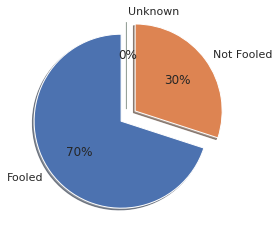

In [ ]:
num_fooled =  fooled[0].shape[0]
num_not_fooled = not_fooled[0].shape[0]
unknown = 100 - num_fooled - num_not_fooled

plt.pie([num_fooled, num_not_fooled, unknown], labels = ['Fooled', 'Not Fooled', 'Unknown'], autopct='%1.f%%', shadow=True, startangle=90, explode=(0.1,0.1,0.1))
plt.show()

##### section c

**A graph describing the loss of the generator and the discriminator:**   

1.   Did the models go “back and forth” with their losses?
2.   Was there a consistent leader?

As we can see, the models are not going "back and forth" with their losses. We also can see that the Discriminator is consistent leader.

##### Evaluate the Quality of the samples that "fooled" the detector

In [ ]:
real_sample_df = df_diabetes.sample(len(fooled_df)).iloc[:,:-1]
real_sample_df = pd.DataFrame(data=diabetes_scaler.inverse_transform(real_sample_df),  columns=['preg',	'plas',	'pres',	'skin',	'insu',	'mass',	'pedi',	'age'])
table_evaluator = TableEvaluator(real_sample_df, fooled_df)

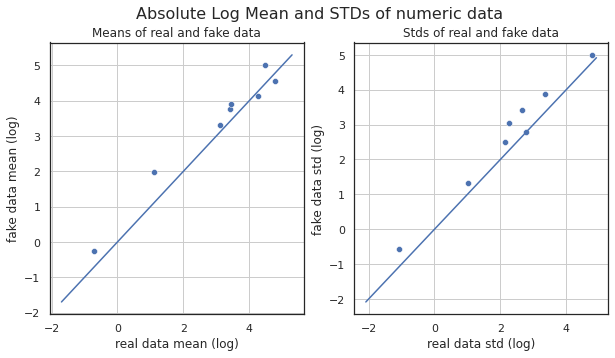

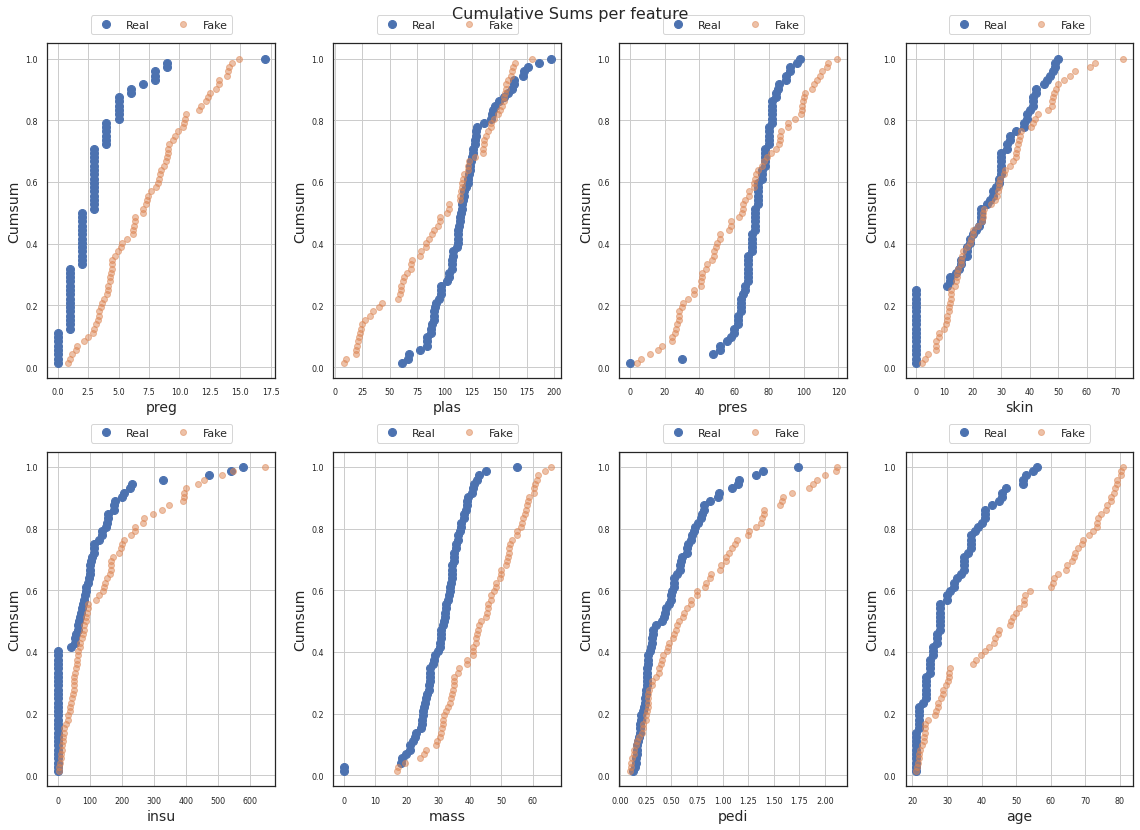

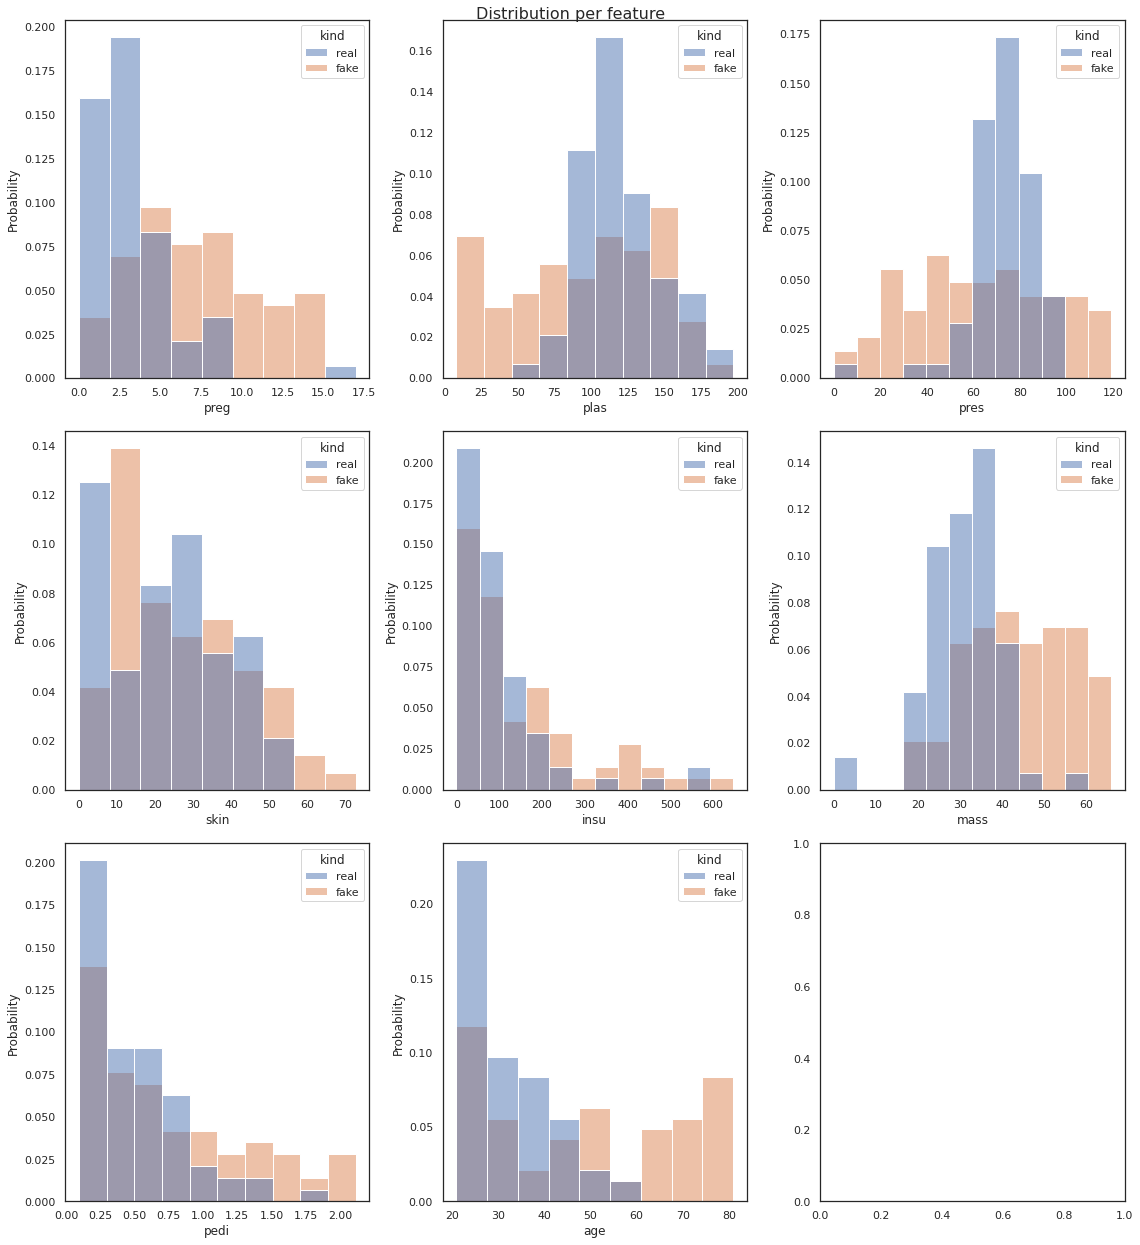

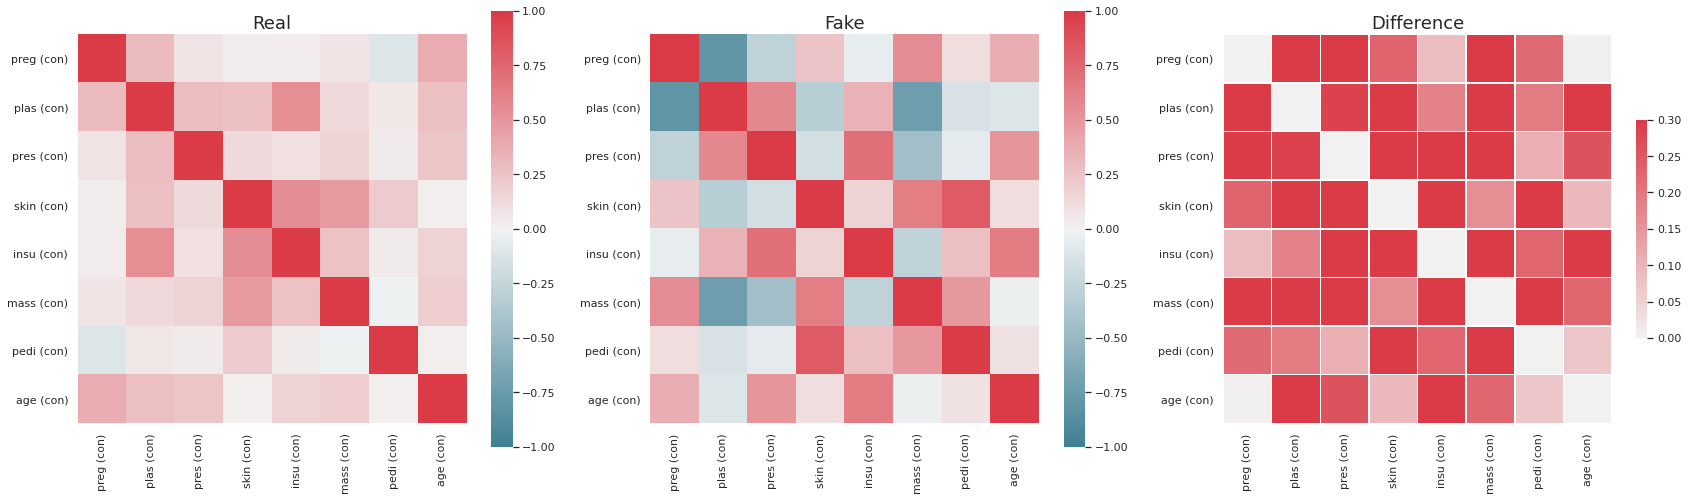

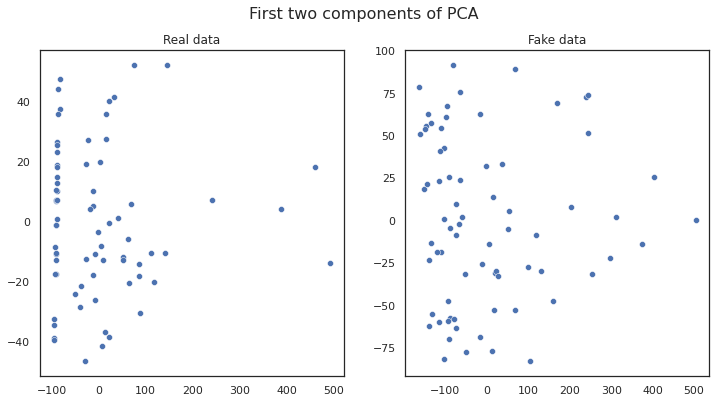

In [ ]:
table_evaluator.visual_evaluation()

#### German Credit

##### section a

In [ ]:
latent_points = generate_latent_points(latent_dim, 100)
X = g_credit_model.predict(latent_points)
data_fake = pd.DataFrame(data=X,  columns=['1',	'2',	'3',	'4',	'5',	'6',	'7',	'8',	'9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])

In [ ]:
X_dis = d_credit_model(data_fake.to_numpy())

In [ ]:
fooled = np.where(np.any(X_dis > 0.5, axis=1))
not_fooled = np.where(np.any(X_dis < 0.5, axis=1))

In [ ]:
data_fake_inv = data_fake
data_fake_inv = pd.DataFrame(data=german_credit_scaler.inverse_transform(data_fake_inv), columns=['1',	'2',	'3',	'4',	'5',	'6',	'7',	'8',	'9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])

for col in data_fake_inv.columns:
  data_fake_inv[col] = data_fake_inv[col].apply(lambda x: int(x))
  if col in label_encoders.keys():
    data_fake_inv[col] = label_encoders[col].inverse_transform(data_fake_inv[col])

**Here a several samples that “fooled” the detector:**


In [ ]:
fooled_df = data_fake_inv.iloc[fooled]
fooled_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,A11,4,A33,A40,6820,A61,A71,2,A91,A101,1,A123,74,A142,A151,1,A173,1,A191,A201
1,A11,4,A32,A40,1704,A62,A71,1,A91,A101,1,A123,61,A142,A151,1,A173,1,A191,A201
2,A12,35,A33,A410,901,A62,A74,2,A91,A102,3,A123,26,A142,A151,2,A171,1,A191,A201
3,A11,4,A32,A40,1514,A61,A72,1,A92,A101,1,A123,39,A142,A151,2,A173,1,A191,A201
4,A13,72,A33,A48,11419,A64,A74,3,A93,A102,3,A121,19,A141,A152,3,A171,1,A191,A202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,A13,71,A33,A43,2842,A63,A74,3,A92,A102,3,A121,20,A141,A152,3,A171,1,A191,A201
96,A13,61,A33,A48,1493,A64,A74,3,A91,A102,3,A123,28,A141,A152,1,A173,1,A191,A201
97,A11,67,A33,A41,3317,A61,A74,3,A91,A102,1,A123,69,A142,A152,3,A171,1,A191,A201
98,A13,71,A31,A48,2055,A64,A74,2,A92,A102,3,A121,19,A141,A152,2,A171,1,A191,A201


**Here a several that did not “fooled” the detector:**


In [ ]:
not_fooled_df = data_fake_inv.iloc[not_fooled]
not_fooled_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
15,A11,9,A33,A41,1179,A62,A74,3,A91,A102,2,A123,38,A142,A151,2,A173,1,A191,A201


##### section b

**Here we generate 100 samples at random after our models converged:**   
How many were able to pass as real samples?

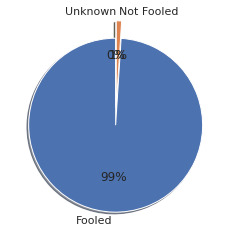

In [ ]:
num_fooled =  fooled[0].shape[0]
num_not_fooled = not_fooled[0].shape[0]
unknown = 100 - num_fooled - num_not_fooled

plt.pie([num_fooled, num_not_fooled, unknown], labels = ['Fooled', 'Not Fooled', 'Unknown'], autopct='%1.f%%', shadow=True, startangle=90, explode=(0.1,0.1,0.1))
plt.show()

##### section c

**A graph describing the loss of the generator and the discriminator:**   

1.   Did the models go “back and forth” with their losses?
2.   Was there a consistent leader?


As we can see, the models are going "back and forth" with their losses. We also can see that there is no consistent leader.

##### Evaluate the Quality of the samples that "fooled" the detector

In [ ]:
real_sample_df = df_german_credit.sample(len(fooled_df)).iloc[:,:-1]
real_sample_df = pd.DataFrame(data=german_credit_scaler.inverse_transform(real_sample_df),  columns=['1',	'2',	'3',	'4',	'5',	'6',	'7',	'8',	'9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20'])
for col in real_sample_df.columns:
  real_sample_df[col] = real_sample_df[col].apply(lambda x: int(x))
  if col in label_encoders.keys():
    real_sample_df[col] = label_encoders[col].inverse_transform(real_sample_df[col])
table_evaluator = TableEvaluator(real_sample_df, fooled_df, cat_cols=label_encoders.keys())

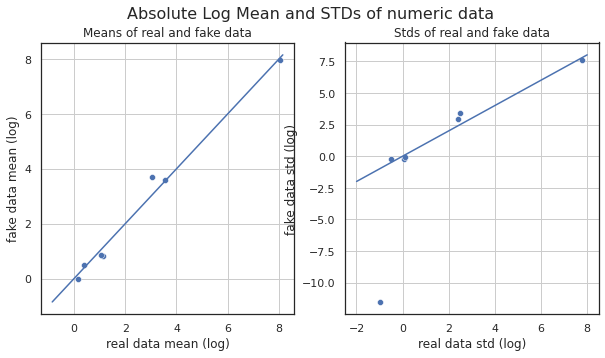

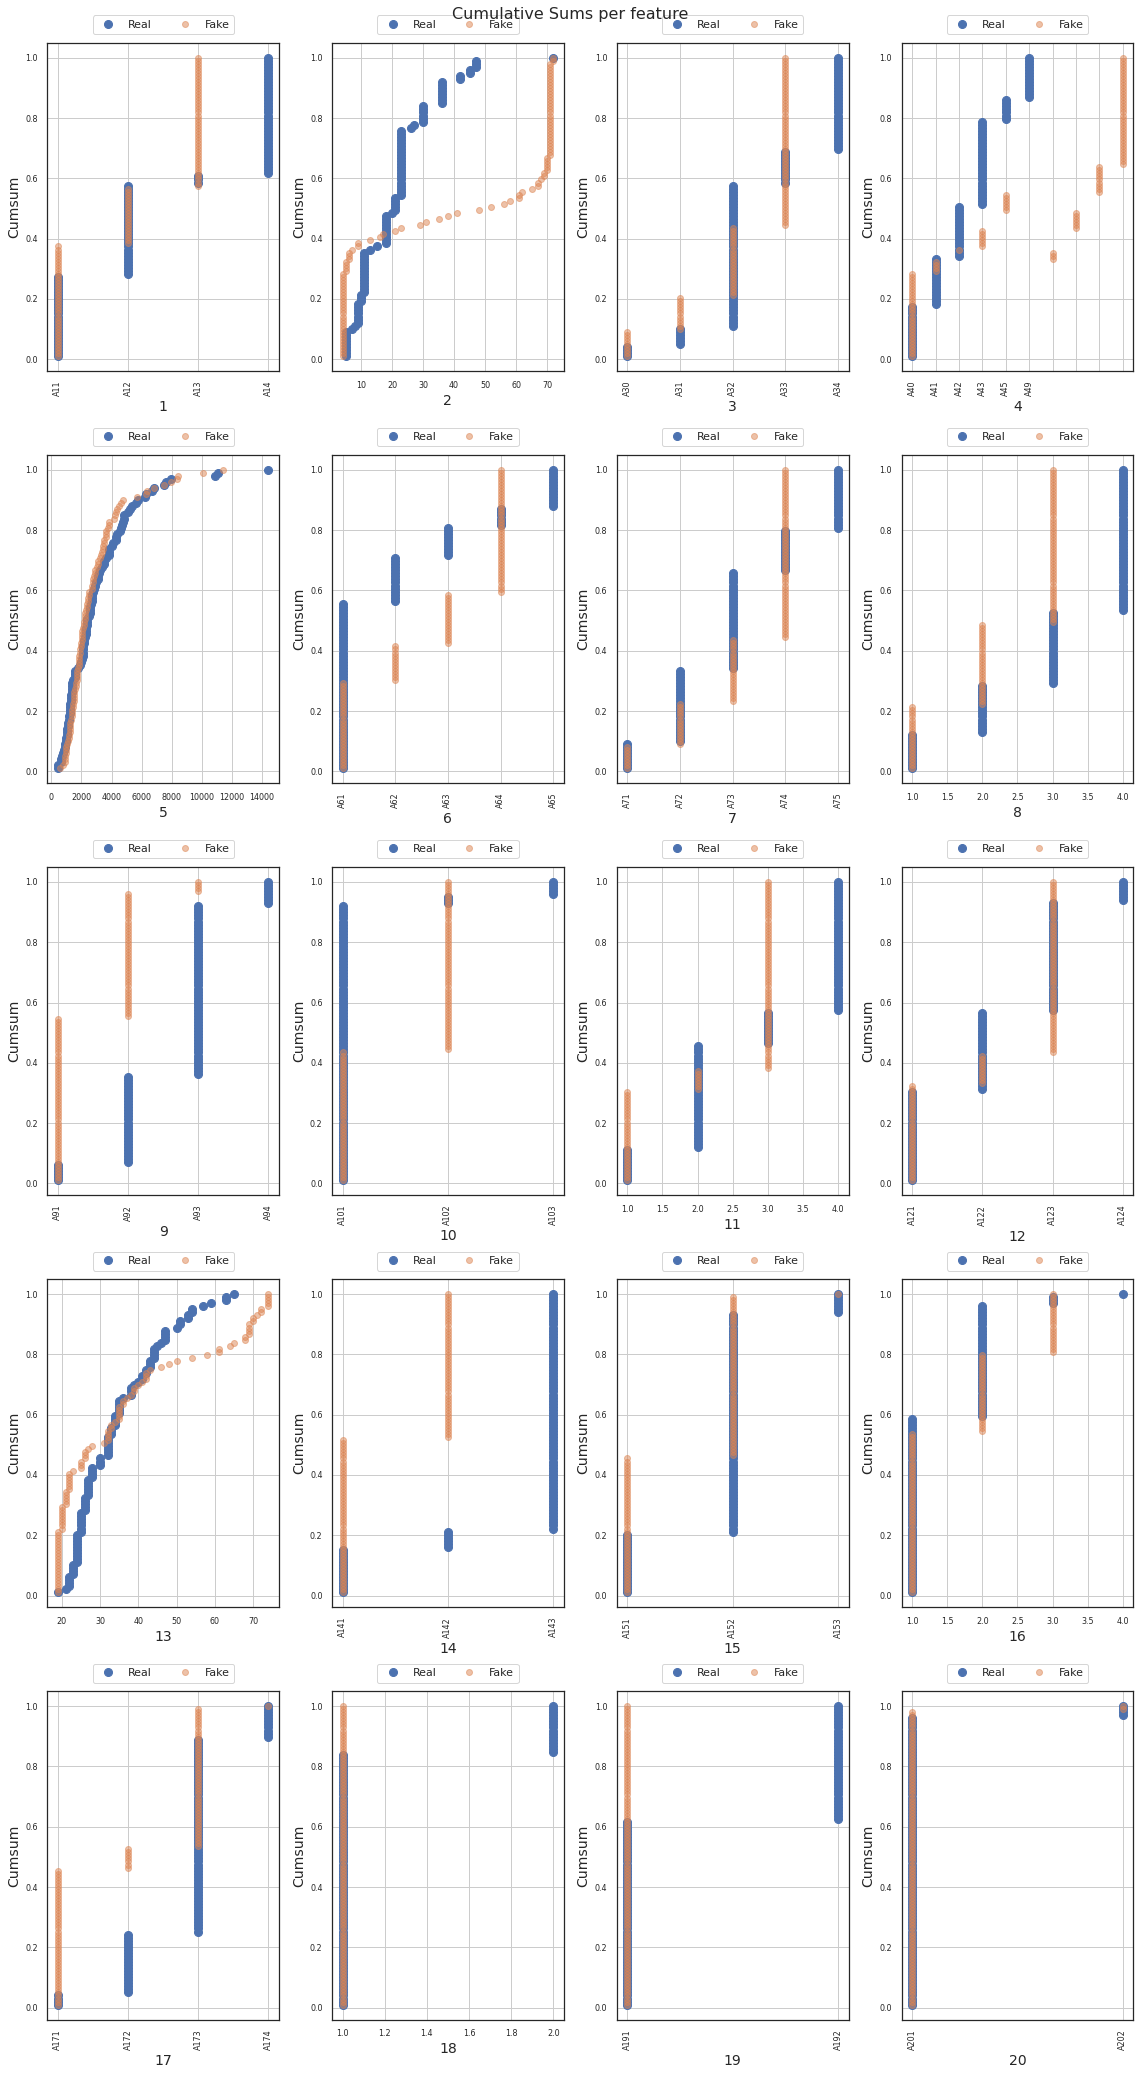

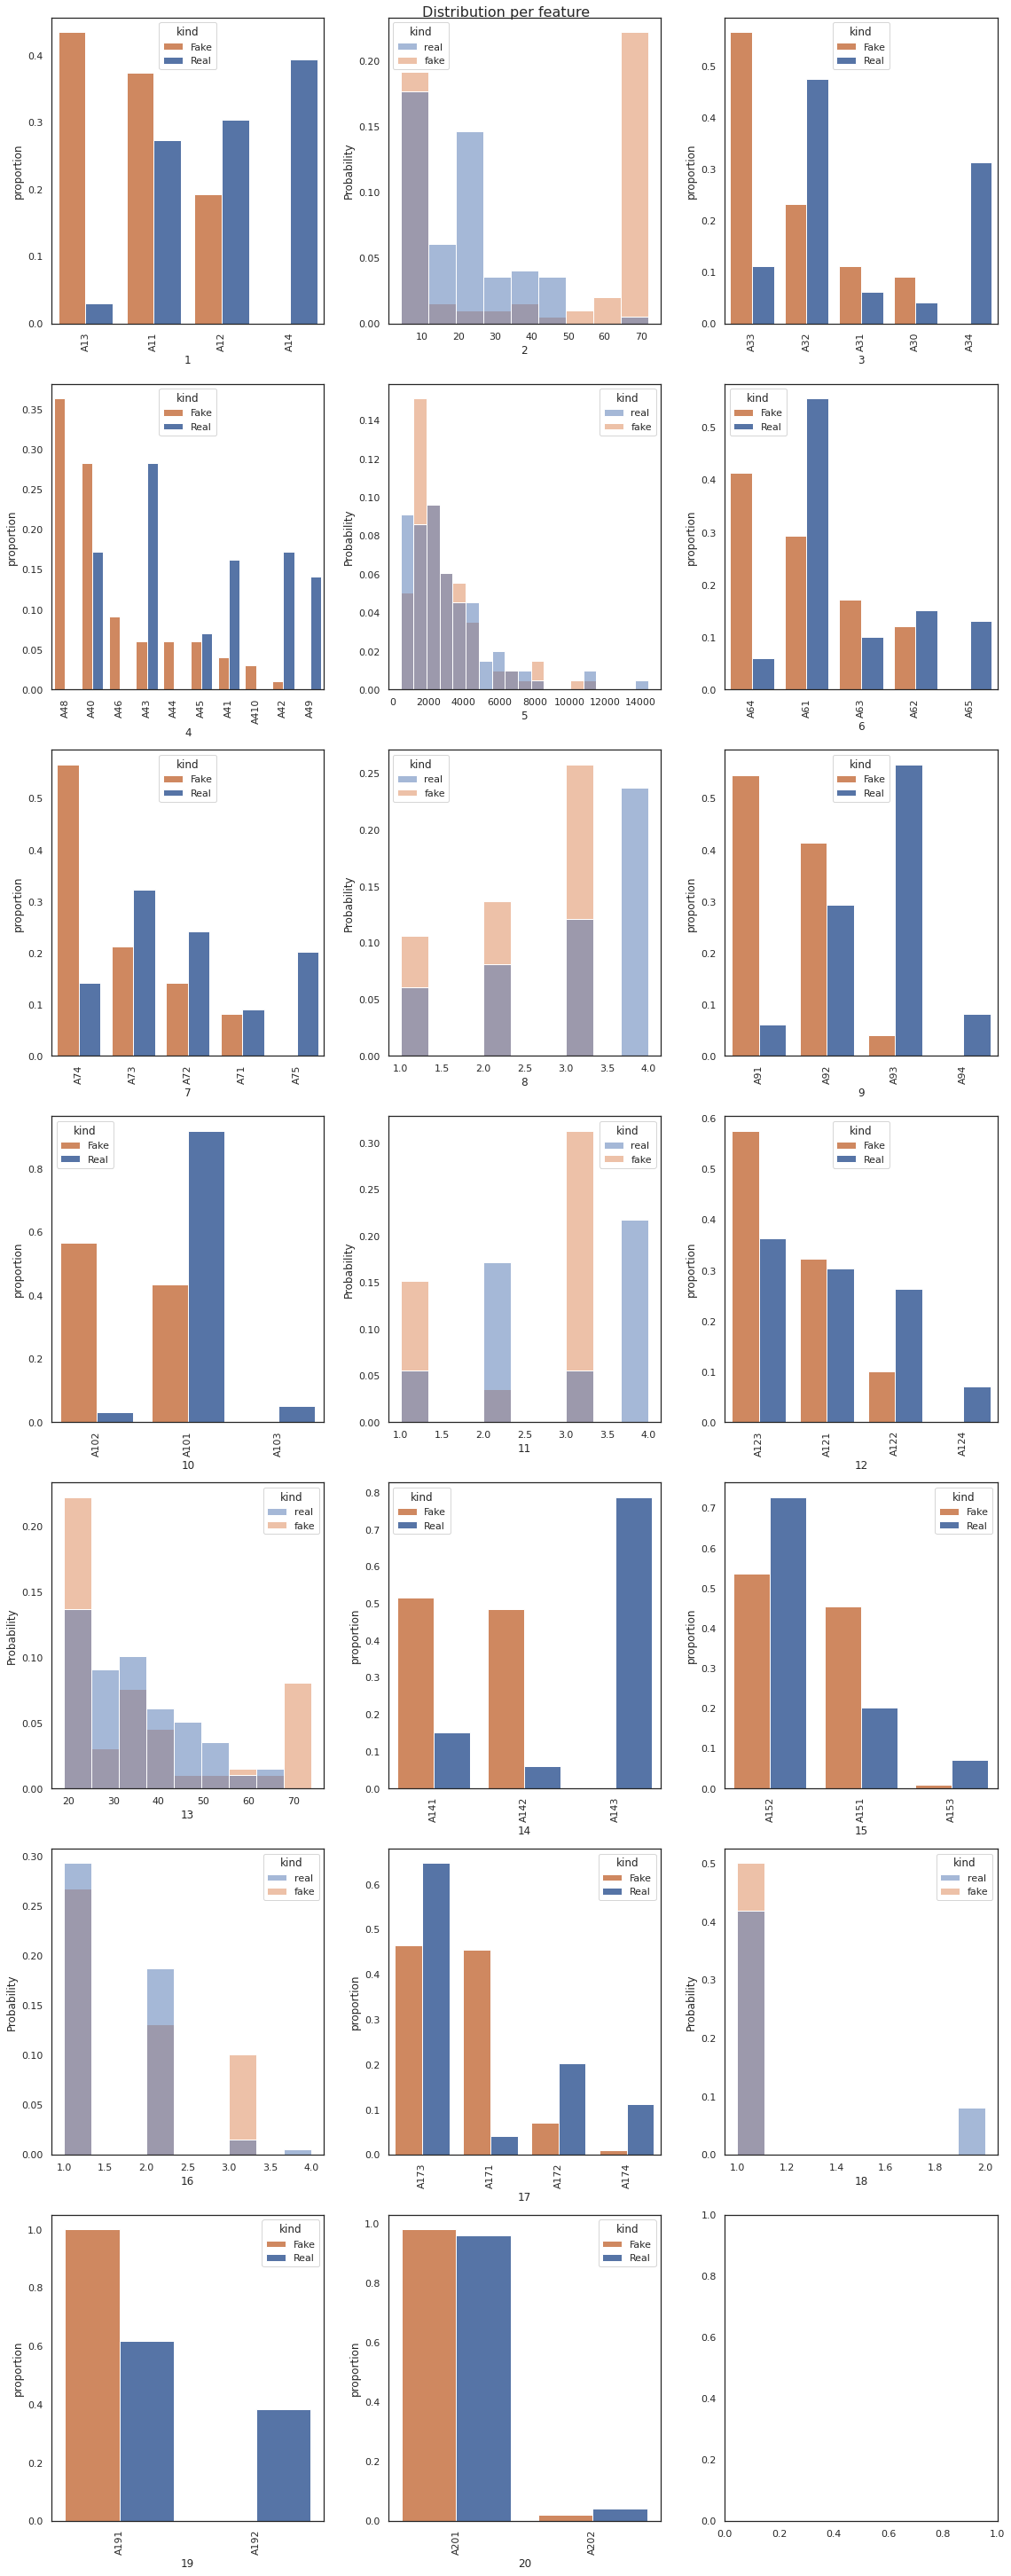

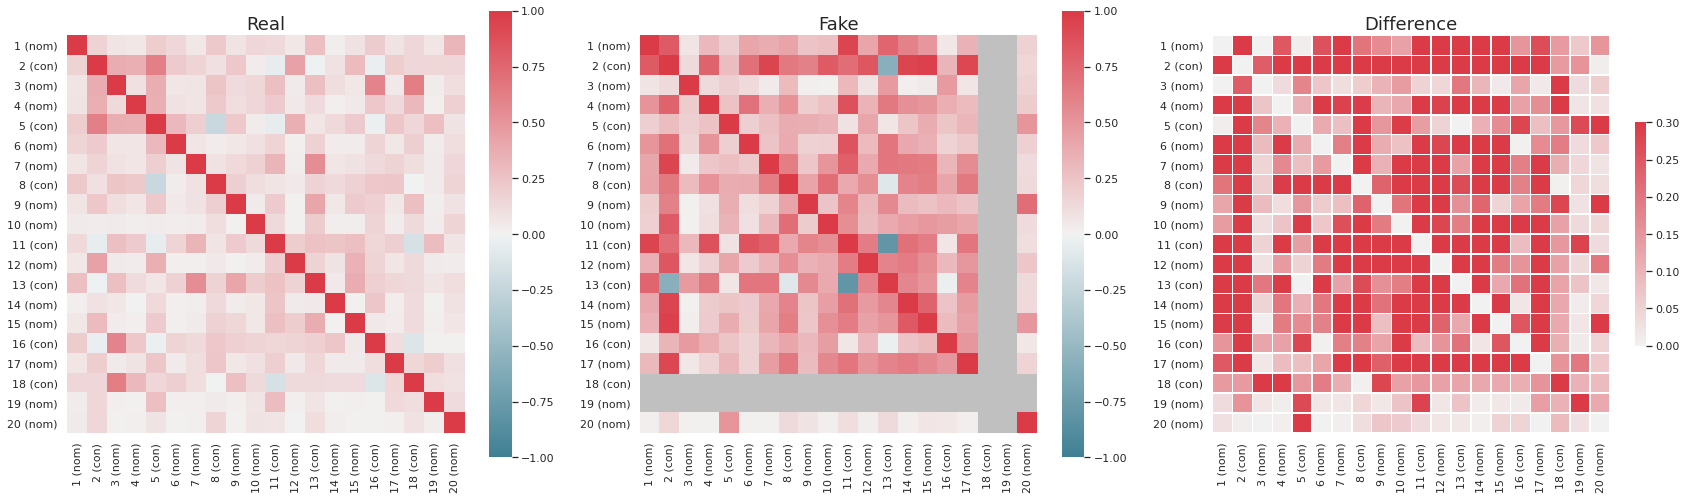

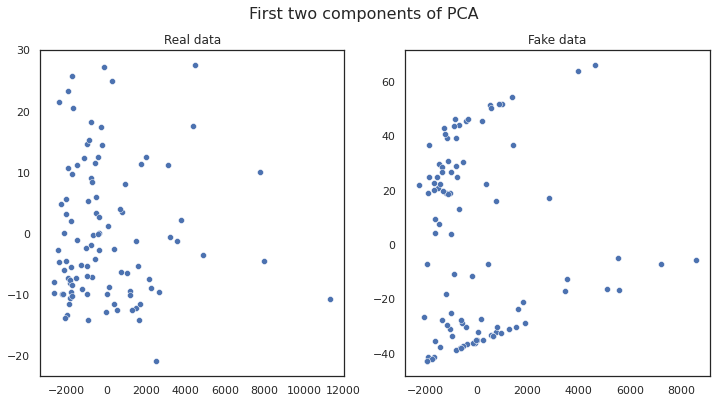

In [ ]:
table_evaluator.visual_evaluation()

## Part 2 – Generative model for sample generation

### Random Forest - Training & Performance

In [ ]:
diabetes_x, diabetes_y = df_diabetes.iloc[:, :-1], df_diabetes.iloc[:, -1]
diabetes_x.shape, diabetes_y.shape

((768, 8), (768,))

In [ ]:
credit_x, credit_y = df_german_credit.iloc[:, :-1], df_german_credit.iloc[:, -1]
credit_x.shape, credit_y.shape

((1000, 20), (1000,))

In [ ]:
# Split to train & test
diabetes_x_train, diabetes_x_test, diabetes_y_train, diabetes_y_test = train_test_split(diabetes_x, diabetes_y, test_size=0.3, random_state=my_seed)
credit_x_train, credit_x_test, credit_y_train, credit_y_test = train_test_split(credit_x, credit_y, test_size=0.3, random_state=my_seed)

In [ ]:
# Create diabetes random forest model and fit model
diabetes_rfc = RandomForestClassifier(n_jobs=-1)
_ = diabetes_rfc.fit(diabetes_x_train.values, diabetes_y_train)

In [ ]:
# Create german credit random forest model and fit model
credit_rfc = RandomForestClassifier(n_jobs=-1)
_ = credit_rfc.fit(credit_x_train.values, credit_y_train)

In [ ]:
def plot_model_score(classifier, x_test, y_test=None):
  if y_test is not None:
    acc = classifier.score(x_test, y_test)
    print("Accuracy: " + str(acc*100) + "%")
  confidence = classifier.predict_proba(x_test)[:, 1]
  max_conf = np.max(confidence)
  min_conf = np.min(confidence)
  avg_conf = np.mean(confidence)

  print("Max confidence: " + str(max_conf))
  print("Min confidence: " + str(min_conf))
  print("Average confidence: " + str(avg_conf))

  plt.hist(confidence)
  plt.xlabel("Confidence")

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Accuracy: 75.75757575757575%
Max confidence: 0.89
Min confidence: 0.0
Average confidence: 0.3295670995670996


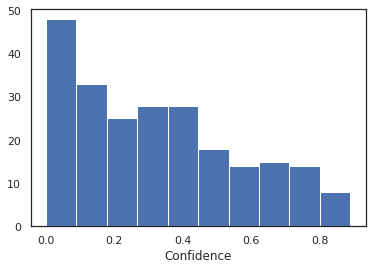

In [ ]:
plot_model_score(diabetes_rfc, diabetes_x_test, diabetes_y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Accuracy: 76.66666666666667%
Max confidence: 1.0
Min confidence: 0.18
Average confidence: 0.6954666666666667


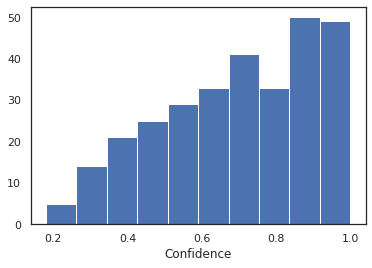

In [ ]:
plot_model_score(credit_rfc, credit_x_test, credit_y_test)

### GAN Architecture & Training

In [ ]:
def define_twist_generator(noise_dim, n_outputs):
  input_z = Input(shape=noise_dim)
  input_c = Input(shape=(1,))
  
  input = Concatenate()([input_z, input_c])

  X = Dense(256, activation = LeakyReLU(alpha=0.2))(input)
  X = BatchNormalization()(X)
  X = Dense(256, activation= LeakyReLU(alpha=0.2))(X)
  X = BatchNormalization()(X)

  output = Dense(n_outputs, activation='sigmoid')(X)

  model = Model(inputs=[input_z, input_c], outputs=output)


  return model

In [ ]:
def define_twist_discriminator(n_inputs):
  input_s = Input(shape=n_inputs)
  input_c = Input(shape=(1,))
  input_y = Input(shape=(1,))

  input = Concatenate()([input_s, input_c, input_y])
  X = Dense(256, activation = LeakyReLU(alpha=0.2))(input)
  X = BatchNormalization()(X)
  X = Dropout(0.2)(X)
  X = Dense(256, activation = LeakyReLU(alpha=0.2))(X)
  X = BatchNormalization()(X)
  X = Dropout(0.2)(X)
  output = Dense(1, activation='sigmoid')(X)

  model = Model(inputs=[input_s, input_c, input_y], outputs=output)

  # compile model
  model.compile(loss='binary_crossentropy', optimizer=Adam(1e-4), metrics=['accuracy'])

  return model

In [ ]:
def create_latent_points(n_samples, latent_dim):
  input_z = tf.random.truncated_normal(shape=[latent_dim*n_samples]).numpy()
  input_z = input_z.reshape(n_samples, latent_dim)
  confidence = np.random.uniform(size=n_samples)

  return input_z, confidence

In [ ]:
def create_fake_samples(g_model, n_samples, latent_dim):
  input_z, input_c = create_latent_points(n_samples, latent_dim)
  x_pred = g_model.predict([np.asarray(input_z), np.asarray(input_c)])

  return x_pred, input_c

In [ ]:
def train_twist(dataset_name, g_model, d_model, rfc, fake_size, latent_dim, n_epochs=1000, n_batch=16):
    my_seed = 10   
    random.seed(my_seed)
    np.random.seed(my_seed)
    tf.random.set_seed(my_seed)
    bc = BinaryCrossentropy()

    d_loss_history = []
    g_loss_history = []
    d_acc_history = []

    batches_in_epoch = int(fake_size / n_batch)
    for epoch in tqdm(range(n_epochs)):
      d_loss_epoch = []
      g_loss_epoch = []
      d_acc_epoch = []

      for batch in range(batches_in_epoch):
        generated_samples, c = create_fake_samples(g_model, n_batch, latent_dim)
        y_out = rfc.predict_proba(generated_samples)[:, 1]

        y = randint(0, 2, n_batch)
        for i in range(n_batch):
            if y[i] == 0:
              temp_c = c[i]
              c[i] = y_out[i]
              y_out[i] = temp_c

        d_loss, d_acc = d_model.train_on_batch([generated_samples, c, y_out], y)
        input_z, c = create_latent_points(n_batch, latent_dim)
        y_gan = np.zeros((n_batch, 1))

        with tf.GradientTape() as gt:
          generated_samples = g_model([input_z, c], training=True)
          y_out = rfc.predict_proba(generated_samples)[:, 1]
          d_res = d_model([generated_samples, c, y_out], training=True)
          g_loss = bc(y_gan, d_res)

        g_grad = gt.gradient(g_loss, g_model.trainable_variables)
        gen_opt = Adam(0.0001)
        gen_opt.apply_gradients(zip(g_grad, g_model.trainable_variables))

        d_loss_epoch.append(d_loss)
        g_loss_epoch.append(g_loss)
        d_acc_epoch.append(d_acc)
      
      d_loss_history.append(np.mean(d_loss_epoch))
      g_loss_history.append(np.mean(g_loss_epoch))
      d_acc_history.append(np.mean(d_acc_epoch))

    plot_history(d_loss_history, g_loss_history)
    plot_accuracy(d_acc_history)
    g_model.save(f'{dataset_name}_trained_generated_model.h5')
    d_model.save(f'{dataset_name}_trained_discriminator_model.h5')

    return g_model, d_model



In [ ]:
def plot_accuracy(model_acc_history):
    plt.plot(model_acc_history)
    plt.title("Accuracy Per Epoch")
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.show()

In [ ]:
def plot_acc_by_conf(y_data, conf):
  _ = plt.plot(conf, y_data, '.')
  _ = plt.plot(np.arange(0,1.1,0.1),np.arange(0,1.1,0.1))
  _ = plt.plot(np.arange(0,1.1,0.1), [0.5]*11, 'g-')
  _ = plt.plot([0.5]*11, np.arange(0,1.1,0.1), 'g-')

In [ ]:
def plot_pca(x_data, samples):
    pca = PCA(n_components=2)

    pc_x = pca.fit_transform(x_data)
    pc_samples = pca.transform(samples)
    
    principalDf_x = pd.DataFrame(data = pc_x, columns = ['pc1', 'pc2'])
    principalDf_samples = pd.DataFrame(data = pc_samples, columns = ['pc1', 'pc2'])
        
    fig, ax = plt.subplots(figsize=(10, 10))
    handles =  [None, None]
    handles[0] = ax.plot(principalDf_x['pc1'],principalDf_x['pc2'],  '.', alpha=0.3, markersize=12)[0]
    handles[1] = ax.plot(principalDf_samples['pc1'],principalDf_samples['pc2'],  '.', alpha=0.7, markersize=12)[0]

    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(handles, ['real', 'samples'])
    plt.show()

### Diabetes

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/200 [00:00<?, ?it/s]

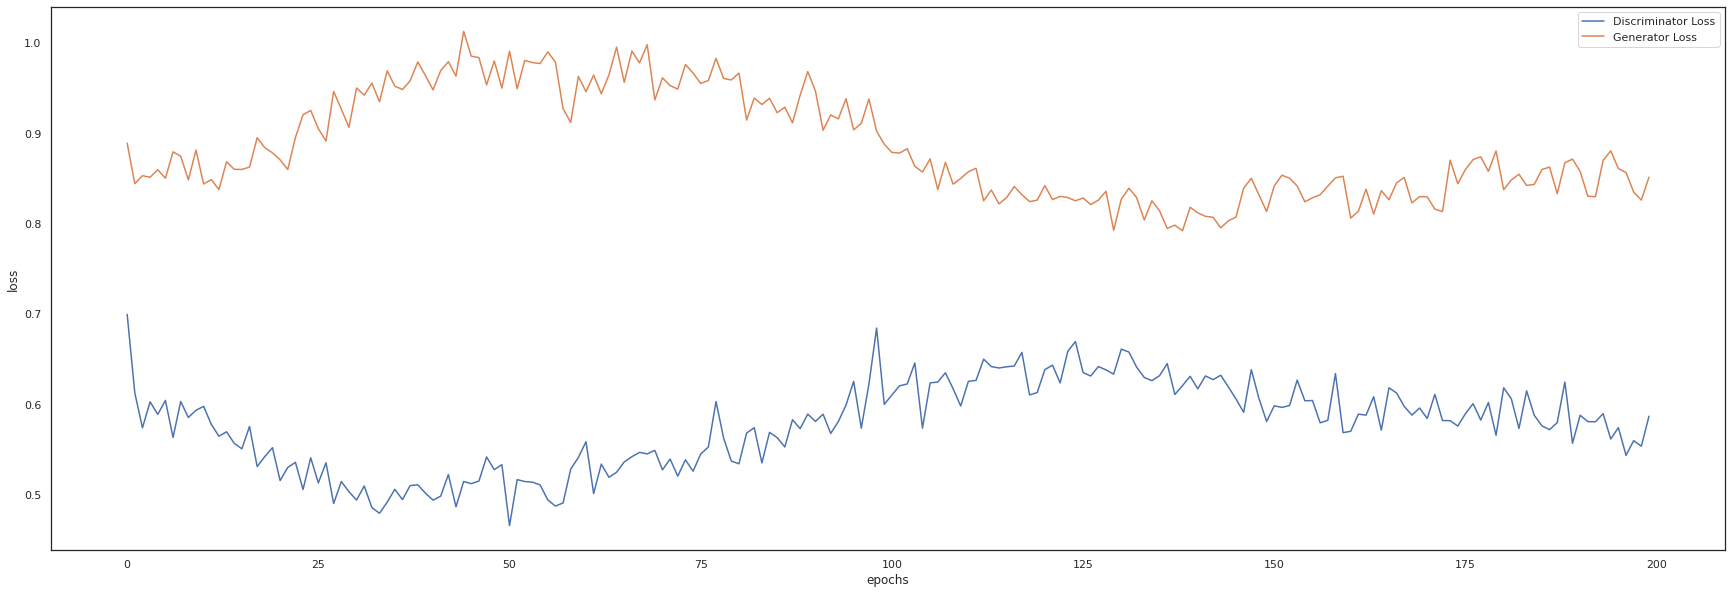

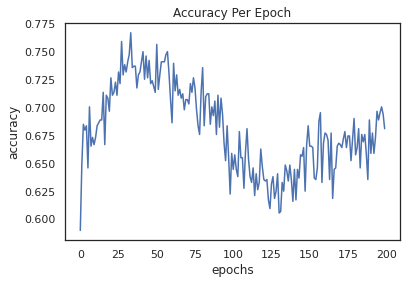

In [ ]:
diabetes_g_model = define_twist_generator(noise_dim=latent_dim, n_outputs=diabetes_x.shape[1])
diabetes_d_model = define_twist_discriminator(n_inputs=diabetes_x.shape[1])
g_diabetes_twist, d_diabetes_twist = train_twist('diabetes', diabetes_g_model, diabetes_d_model, diabetes_rfc, diabetes_x.shape[0], latent_dim=latent_dim, n_epochs=200)

In [ ]:
diabetes_samples, diabetes_conf = create_fake_samples(g_diabetes_twist, n_samples=1000, latent_dim=latent_dim)

Max confidence: 0.89
Min confidence: 0.0
Average confidence: 0.48194


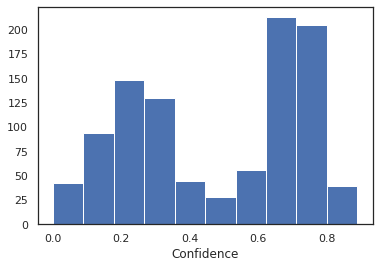

In [ ]:
plot_model_score(diabetes_rfc, diabetes_samples)

In [ ]:
diabetes_y = diabetes_rfc.predict_proba(diabetes_samples)[:, 1]

Accuracy of Prediction by Confidence 92.2%


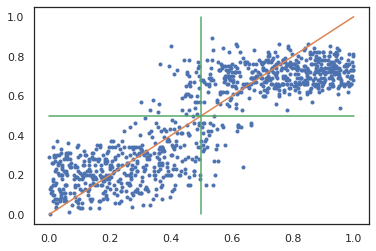

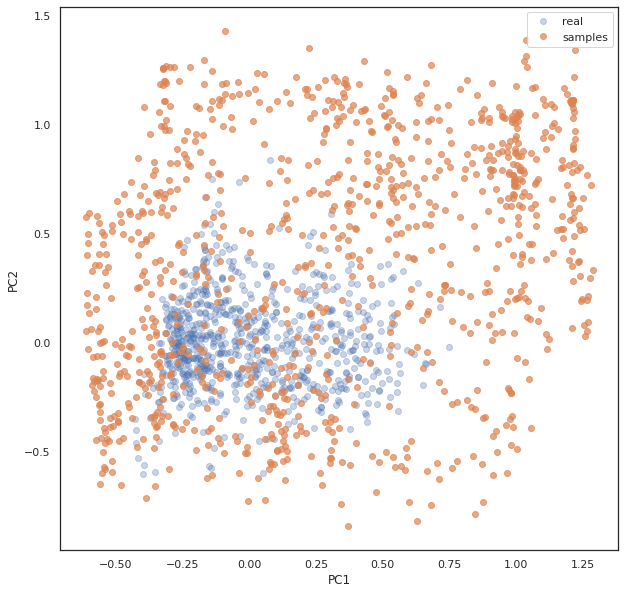

In [ ]:
acc = accuracy_score(np.around(diabetes_y), np.around(diabetes_conf)) * 100
print('Accuracy of Prediction by Confidence ' + str(acc) + '%')
plot_acc_by_conf(diabetes_y, diabetes_conf)
plot_pca(diabetes_x.values, diabetes_samples)

### German Credit

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]


  0%|          | 0/200 [00:00<?, ?it/s]

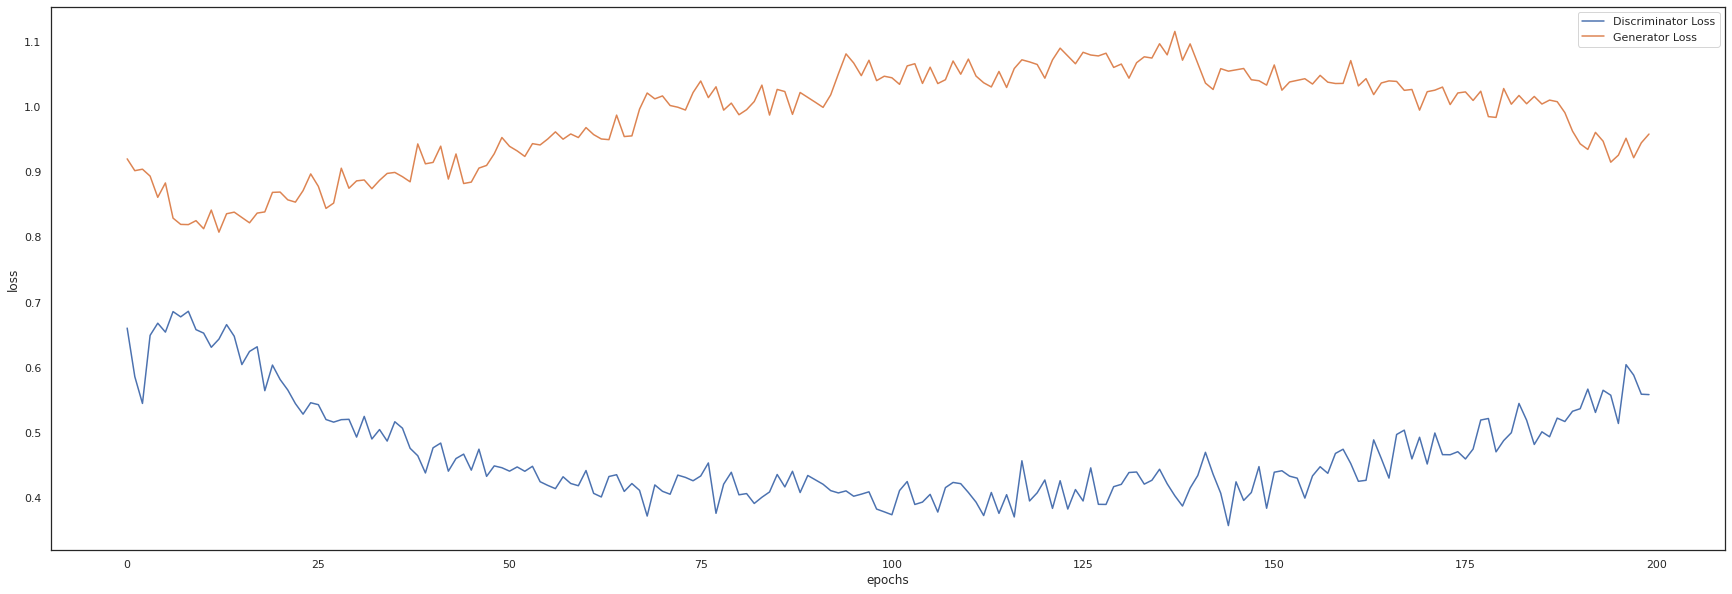

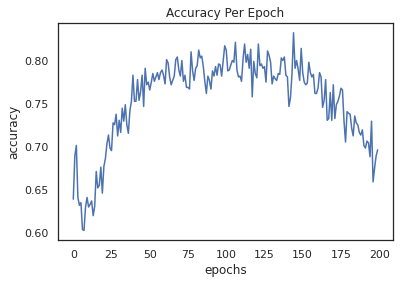

In [ ]:
credit_g_model = define_twist_generator(noise_dim=latent_dim, n_outputs=credit_x.shape[1])
credit_d_model = define_twist_discriminator(n_inputs=credit_x.shape[1])
g_credit_twist, d_credit_twist = train_twist('credit', credit_g_model, credit_d_model, credit_rfc, credit_x.shape[0], latent_dim=latent_dim, n_epochs=200)

In [ ]:
credit_samples, credit_conf = create_fake_samples(g_credit_twist, n_samples=1000, latent_dim=latent_dim)

Max confidence: 0.95
Min confidence: 0.14
Average confidence: 0.5506899999999999


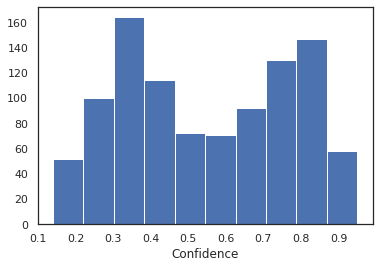

In [ ]:
plot_model_score(credit_rfc, credit_samples)

In [ ]:
credit_y = credit_rfc.predict_proba(credit_samples)[:, 1]

Accuracy of Prediction by Confidence 89.9%


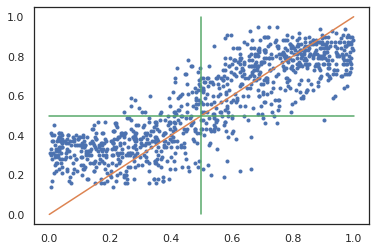

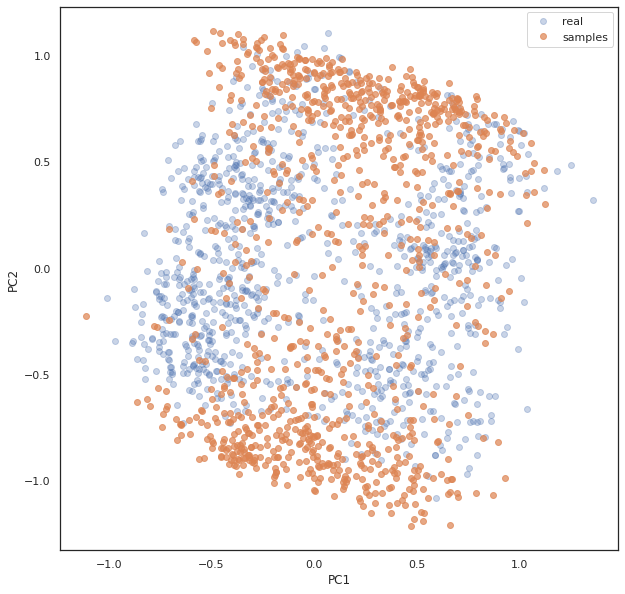

In [ ]:
acc = accuracy_score(np.around(credit_y), np.around(credit_conf)) * 100
print('Accuracy of Prediction by Confidence ' + str(acc) + '%')
plot_acc_by_conf(credit_y, credit_conf)
plot_pca(credit_x.values, credit_samples)